In [119]:
import pandas as pd
import numpy as np
from io import StringIO
import re
from scipy.optimize import fsolve
from astropy import constants as const
import emcee
import corner
import matplotlib.pyplot as plt

In [135]:
from tools import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we will generate our data (radial velocity values) using a simulation!

The radial velocity of a star in a binary system is given by:
$$v(t) = \kappa[cos(f+\omega)+e \cos\omega + v_0$$
where
$$\kappa =\dfrac{(2\pi G)^{1/3}m\sin I}{T^{1/3}(M+m)^{2/3}\sqrt{1-e^2}}$$

$$tan(f/2)= \sqrt{\dfrac{1+e}{1-e}}\tan(u/2)$$

$$u-e\sin u = \dfrac{2\pi}{T}(t-\tau)$$

#### insert descr. of parameters!!!!!!!!! ####

To generate values for the uncertainty, we want to determine what factors will influence the uncertainty value. We first looked for a correlation between radial velocity and uncertainty. Plotting the relationship between radial velocity and uncertainty for some sample systems, we get the following:

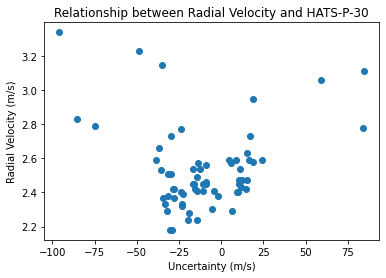

In [128]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

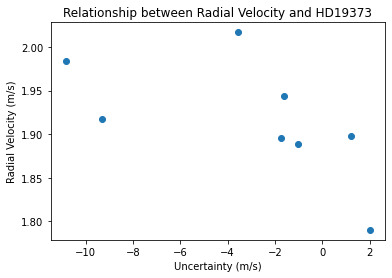

In [129]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

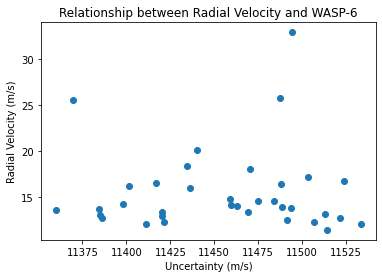

In [130]:
# selecting a random plot from directory
all_files = list_files('data')
index = np.random.randint(0, len(all_files))

plot_uncertainty_for_file(all_files[index])

From the sample plots, there doesn't really seem to be a clear correlation between radial velocity and uncertainty. We can also plot all radial velocity values and uncertainties across all datasets:

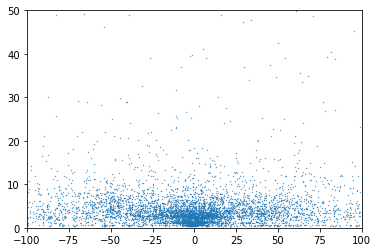

In [137]:
plot_uncertainty_correlation()

Since there really isn't an obvious correlation, we will assume that the value of radial velocity has no effect on the associated value of uncertainty. We will assume that the telescope used will uniquely determine 

In [38]:
def plot_uncertainty_histogram(telescope, bins=100):
    """(str, int, tup) -> ()
    Plots histogram of uncertainty values
    """
    unc = get_uncertainties(telescope)
    plt.hist(unc, bins=bins)
    plt.xlabel('Uncertainty Range')
    plt.ylabel('Number of Samples')
    plt.title(f'Histogram from Uncertainties of {telescope} Telescope')

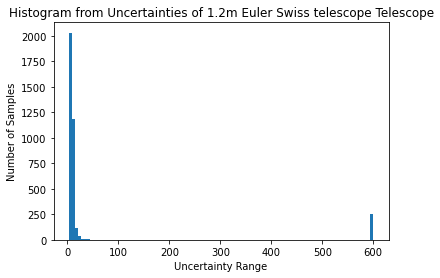

In [42]:
plot_uncertainty_histogram("1.2m Euler Swiss telescope")

In [115]:
plot_uncertainty_histogram("8.2m Antu (UT1)")

ValueError: No files with this instrument found.

In [12]:
df = get_data('UID_0007513_RVC_005.tbl')
unc = df.iloc[:, 2]
print(list(unc), unc)

[8.0, 7.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 10.0, 8.0, 7.0, 7.0, 8.0, 8.0, 7.0, 7.0, 8.0, 8.0, 8.0, 7.0, 7.0, 9.0, 9.0, 8.0, 7.0, 8.0, 8.0, 7.0, 8.0, 10.0, 11.0, 8.0, 7.0, 7.0, 8.0, 8.0, 11.0, 8.0, 8.0, 9.0, 9.0, 10.0, 11.0, 12.0, 13.0, 9.0, 12.0, 8.0, 8.0, 8.0, 8.0, 7.0, 9.0, 8.0, 7.0, 8.0, 9.0, 8.0, 9.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 8.0, 9.0, 8.0, 8.0] 0     8.0
1     7.0
2     8.0
3     8.0
4     8.0
     ... 
66    7.0
67    8.0
68    9.0
69    8.0
70    8.0
Name: 2, Length: 71, dtype: float64


In [17]:
get_uncertainties("3.9m Anglo-Australian Telescope (AAT)")

[4.6,
 7.7,
 5.5,
 5.8,
 7.5,
 4.9,
 4.4,
 4.7,
 5.7,
 5.8,
 7.1,
 8.3,
 4.7,
 9.0,
 3.7,
 4.4,
 3.7,
 3.7,
 4.1,
 4.0,
 4.1,
 3.3,
 3.8,
 3.4,
 4.6,
 3.4,
 3.7,
 6.0,
 3.3,
 3.3,
 3.3,
 3.5,
 4.9,
 3.0,
 5.2,
 3.6,
 3.9,
 4.0,
 4.4,
 5.1,
 3.5,
 3.8,
 2.9,
 3.2,
 3.6,
 3.4,
 3.4,
 4.2,
 3.5,
 3.0,
 2.9,
 4.8,
 3.8,
 3.6,
 3.4,
 3.4,
 3.0,
 4.2,
 9.9,
 4.4,
 4.6,
 3.3,
 4.8,
 6.5,
 10.0,
 4.3,
 3.8,
 4.3,
 4.1,
 4.6,
 3.9,
 2.6,
 3.9,
 2.2,
 3.1,
 3.1,
 6.7,
 3.3,
 3.0,
 2.7,
 3.7,
 3.9,
 6.2,
 4.2,
 3.6,
 3.6,
 2.7,
 4.3,
 4.2,
 5.1,
 4.7,
 4.9,
 5.6,
 5.9,
 4.5,
 5.3,
 5.6,
 9.9,
 4.7,
 4.6,
 8.6,
 9.3,
 4.0,
 6.0,
 4.9,
 4.0,
 4.3,
 4.0,
 5.0,
 4.2,
 3.6,
 4.2,
 5.8,
 5.9,
 6.1,
 7.0,
 5.2,
 8.1,
 5.3,
 5.8,
 5.8,
 5.9,
 5.4,
 4.8,
 6.7,
 4.5,
 4.5,
 3.9,
 4.9,
 5.0,
 5.9,
 5.9,
 3.6,
 4.9,
 5.0,
 5.4,
 4.8,
 3.8,
 3.7,
 5.8,
 4.6,
 5.5,
 5.7,
 12.0,
 3.9,
 5.6,
 4.0,
 2.4,
 2.2,
 2.0,
 2.4,
 2.2,
 2.3,
 2.8,
 2.5,
 2.5,
 3.2,
 2.6,
 3.9,
 2.7,
 2.3,
 3.4,
 3.2,
 3.0,
 2.8,
 3.9,
 3

In [6]:
find_files_for_telescope("1.93m")

['UID_0065721_RVC_002.tbl',
 'UID_0300068_RVC_002.tbl',
 'UID_0024205_RVC_005.tbl',
 'UID_0101966_RVC_003.tbl',
 'UID_0113357_RVC_003.tbl',
 'UID_0080076_RVC_004.tbl',
 'UID_0042723_RVC_003.tbl',
 'UID_0300036_RVC_001.tbl',
 'UID_0300068_RVC_001.tbl',
 'UID_0006643_RVC_003.tbl',
 'UID_0300018_RVC_001.tbl',
 'UID_0096507_RVC_002.tbl',
 'UID_0300056_RVC_002.tbl',
 'UID_0300074_RVC_004.tbl',
 'UID_0043587_RVC_005.tbl',
 'UID_0300056_RVC_001.tbl',
 'UID_0300078_RVC_001.tbl',
 'UID_0017747_RVC_001.tbl',
 'UID_0300017_RVC_001.tbl',
 'UID_0073146_RVC_002.tbl',
 'UID_0096441_RVC_002.tbl',
 'UID_0073146_RVC_001.tbl',
 'UID_0096441_RVC_001.tbl',
 'UID_0300067_RVC_003.tbl',
 'UID_0059610_RVC_003.tbl',
 'UID_0108859_RVC_004.tbl',
 'UID_0081022_RVC_001.tbl',
 'UID_0300050_RVC_001.tbl',
 'UID_0094075_RVC_003.tbl',
 'UID_0300083_RVC_001.tbl',
 'UID_0116727_RVC_003.tbl',
 'UID_0053721_RVC_002.tbl',
 'UID_0030905_RVC_003.tbl',
 'UID_0030905_RVC_002.tbl',
 'UID_0300084_RVC_001.tbl',
 'UID_0045982_RVC_00

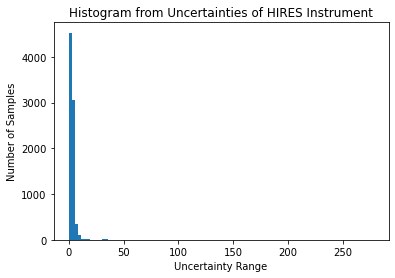

In [112]:
plot_instrumental_uncertainty_hist("HIRES", bins=100)

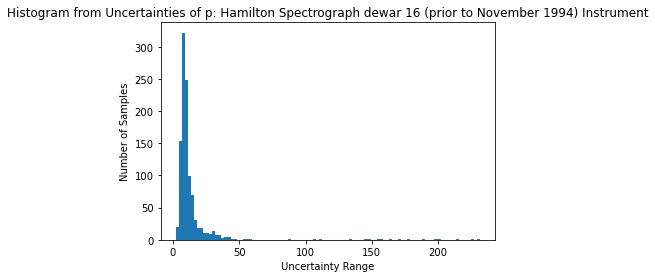

In [113]:
plot_instrumental_uncertainty_hist('p: Hamilton Spectrograph dewar 16 (prior to November 1994)', bins=100)

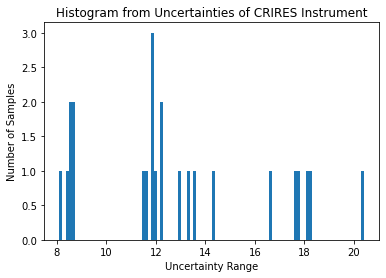

In [114]:
plot_instrumental_uncertainty_hist("CRIRES", bins=100)

Now, we will try to recover these parameter values using an MCMC!